In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
def data_pre(df):
    df = df[['userId','movieId','rating']]

    User = pd.DataFrame(df[['userId']].value_counts())
    User.reset_index(inplace = True)
    User = User[User[0] > 9]

    Item = pd.DataFrame(df[['movieId']].value_counts())
    Item.reset_index(inplace = True)
    Item = Item[Item[0] > 9]

    final_user = User['userId'].unique()
    final_item = Item['movieId'].unique()

    df = df[df['movieId'].isin(final_item)]
    df = df[df['userId'].isin(final_user)]
    df = df.reset_index(drop = True)
    
    return df

In [3]:
def pair_mat(df):
    user_set = sorted(df['userId'].unique())
    item_set = sorted(df['movieId'].unique())

    n_users = len(user_set)
    n_items = len(item_set)

    pair_mat = np.zeros((n_users, n_items))
    pair_mat = pd.DataFrame(pair_mat, index = user_set, columns = item_set)

    for i in range(len(df)):
        pair_mat.loc[df.loc[i,'userId']][df.loc[i,'movieId']] = 1
    
    return pair_mat

In [4]:
def test_train_split(pair_mat): 
    test_list = []
    train_mat = pair_mat.copy()

    for i in range(train_mat.shape[0]):
        temp = train_mat.iloc[i,:]
        test_idx = np.random.choice(np.where(temp == 1)[0])
        train_mat.iloc[i,test_idx] = 0
        test_list.append((i,test_idx))
    
    return test_list, train_mat

In [5]:
def bootstrap(train_mat): 
    u = np.random.choice(range(train_mat.shape[0]))
    temp = train_mat.iloc[u,:]
    i = np.random.choice(np.where(temp == 1)[0])
    j = np.random.choice(np.where(temp == 0)[0])
    return (u,i,j)

In [6]:
def run(train_mat):
    n_dim, epoch, learning_rate, ld = 20, 500000, 0.01, 0.0001

    user_mat = np.random.random((train_mat.shape[0], n_dim))
    item_mat = np.random.random((train_mat.shape[1], n_dim))

    pred, aucs, epochs = [], [], []

    for epoch in range(epoch):
        u, i, j = bootstrap(train_mat)
        
        W_u, H_i ,H_j  = user_mat[u, : ], item_mat[i, : ], item_mat[j, : ]
        
        x_uij = np.dot(W_u, H_i) - np.dot(W_u, H_j) # x_ui - x_uj

        grad = np.exp(-x_uij) / (1 + np.exp(-x_uij))

        user_mat[u, : ] = user_mat[u, : ] + learning_rate * (grad * (H_i - H_j) + ld * (W_u))
        item_mat[i, : ] = item_mat[i, : ] + learning_rate * (grad * W_u + ld * (H_i))
        item_mat[j, : ] = item_mat[j, : ] + learning_rate * (-(grad * W_u) + ld * (H_j))

        pred.append(x_uij)

        if epoch % 10000 == 0 :
            auc = np.where(np.array(pred) > 0, 1, 0).mean()
            epochs.append(epoch)
            aucs.append(auc)
            
    return epochs, aucs

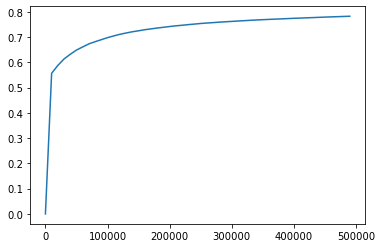

In [7]:
df = pd.read_csv("ratings.csv")

df = data_pre(df)

pair_mat = pair_mat(df)

test_list, train_mat = test_train_split(pair_mat)

epochs, aucs = run(train_mat)

aucs[0]= 0

plt.plot(epochs, aucs)
plt.show()